In [108]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from modeler_strats.universal_modeler import UniversalModeler
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
import math

In [109]:
start_date = datetime(2023,1,1)
end_date = datetime.now()

In [110]:
market = Market()
speculation_db = ADatabase("btc_spec")
classification_db = ADatabase("btc_spec_classification")
window_db = ADatabase("btc_window")
rolling_db = ADatabase("btc_rolling")
current_db = ADatabase("btc_current")
umod = UniversalModeler()

In [111]:
market.connect()
prices = market.retrieve("crypto")
market.disconnect()
current_prices = pd.read_csv("./csv_files/prices/BTC-USD.csv")
current_prices["ticker"] = "BTC"
current_prices = p.column_date_processing(current_prices)
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]
prices["ticker"] = "BTC"
prices = pd.concat([prices,current_prices])

In [112]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
bench["day"] = [x.weekday() for x in bench["date"]]
bench_returns = bench.copy()
bench_returns[f"bench_return"] = (bench_returns["adjclose"].shift(-1) - bench_returns["adjclose"]) / bench_returns["adjclose"]
bench_quarterlies = bench_returns.groupby(["year","quarter"]).agg({"adjclose":"first"}).reset_index().rename(columns={"adjclose":"quarter_start"})
bench_returns = bench_returns.merge(bench_quarterlies,on=["year","quarter"])
bench_returns[f"bench_quarterly_return"] = (bench_returns["adjclose"].shift(-1) - bench_returns["quarter_start"]) / bench_returns["quarter_start"]
bench_returns["variance"] = bench_returns["bench_return"].rolling(window=14).var()
bench_returns["quarterly_variance"] = bench_returns["bench_quarterly_return"].rolling(window=14).var()
bench_returns = bench_returns.dropna()

In [113]:
tyields = pd.read_csv("./csv_files/FED/DGS1.csv")
tyields = p.column_date_processing(tyields)
tyields["dgs1"] = tyields["dgs1"].replace(".",0)
tyields["dgs1"] = tyields["dgs1"].astype("float")
tyields["yield"] = [1+(x/100) for x in tyields["dgs1"]]
tyields["weekly_yield"] = [math.exp(math.log(x)/52) for x in tyields["yield"]]
tyields

,date,dgs1,year,quarter,week,yield,weekly_yield
0,1962-01-02,3.22,1962,1,1,1.0322,1.000610
1,1962-01-03,3.24,1962,1,1,1.0324,1.000613
2,1962-01-04,3.24,1962,1,1,1.0324,1.000613
3,1962-01-05,3.26,1962,1,1,1.0326,1.000617
4,1962-01-08,3.31,1962,1,2,1.0331,1.000626
...,...,...,...,...,...,...,...
16013,2023-05-19,5.02,2023,2,20,1.0502,1.000942
16014,2023-05-22,5.07,2023,2,21,1.0507,1.000952
16015,2023-05-23,5.06,2023,2,21,1.0506,1.000950
16016,2023-05-24,5.12,2023,2,21,1.0512,1.000961


In [114]:
factors = [str(x) for x in range(14)]
included_columns=[
    "year",
    "week",
    "ticker",
    "adjclose",
    "y"
]
included_columns.extend(factors)

In [115]:
classification_factors = ["d1","d2","d3","rolling14"]
included_columns.extend(classification_factors)

In [116]:
trades = []
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 1
training_year = 4
strats = ["spec","rolling","window"]
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    for hedge in hedges:
                        for signal in signals:
                            for req in reqs:
                                parameter = {
                                            "value":value
                                             ,"classification":classification
                                             ,"ceiling":ceiling
                                             ,"floor":floor
                                             ,"hedge":hedge
                                             ,"signal":signal
                                             ,"req":req
                                             ,"training_years":training_year
                                            ,"strat":strat
                                            }
                                parameters.append(parameter)

In [117]:
market.connect()
prices = market.retrieve("crypto")
market.disconnect()
current_prices = pd.read_csv("./csv_files/prices/BTC-USD.csv")
current_prices["ticker"] = "BTC"
current_prices = p.column_date_processing(current_prices)
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]
prices["ticker"] = "BTC"
prices = pd.concat([prices,current_prices])

In [118]:
ticker_data = prices.copy()
ticker_data.sort_values("date",ascending=True,inplace=True)
ticker_data["adjclose"] = [float(x) for x in ticker_data["adjclose"]]
ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
for i in range(14):
    ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=1)
ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
ticker_data["rolling14"] = ticker_data["adjclose"].rolling(window=14).mean()
ticker_data.dropna(inplace=True)
ticker_data["ticker"] = "BTC"
ticker_data["y"] = ticker_data["adjclose"].shift(-1)
ticker_data = ticker_data[included_columns]
data = ticker_data.copy().dropna()

In [119]:
prediction_slice = data[data["year"]>=start_date.year-2].reset_index(drop=True)

In [120]:
speculation_db.connect()
models = speculation_db.retrieve("models")
speculation_db.disconnect()

In [121]:
simulation = umod.recommend(models,prediction_slice.copy(),factors)
simulation["week"] = simulation["week"] + 1
simulation["prediction"] = (simulation["cat_prediction"] + simulation["xgb_prediction"] + simulation["tf_prediction"]) / 3

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-03 11:19:38         2522
metadata.json                                  2023-03-03 11:19:38           64
variables.h5                                   2023-03-03 11:19:38        84160
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_absolute_percentage_error
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
4/4 [==============================] - 0s 1ms/step


In [122]:
classification_db.connect()
classification_models = classification_db.retrieve("models")
classification_db.disconnect()

In [123]:
classification_simulation = umod.recommend(classification_models,prediction_slice.copy(),classification_factors)
classification_simulation["week"] = classification_simulation["week"] + 1
classification_simulation["classification_prediction"] = ((classification_simulation["cat_prediction"] + \
                                                          classification_simulation["xgb_prediction"] + \
                                                          classification_simulation["tf_prediction"]) / 3) > 0.5
classification_simulation["classification_prediction"] = [int(x) for x in classification_simulation["classification_prediction"]]

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 10:52:04         2149
metadata.json                                  2023-03-30 10:52:04           64
variables.h5                                   2023-03-30 10:52:04        23208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
4/4 [==============================] - 0s 1ms/step


In [124]:
ticker_sim = prices.copy()
ticker_sim = ticker_sim[(ticker_sim["date"]>=(start_date-timedelta(days=365)))]
for i in range(2,5):
    ticker_sim[f"return_{i}"] = (ticker_sim["adjclose"].shift(-i) - ticker_sim["adjclose"].shift(-1)) / ticker_sim["adjclose"].shift(-1)
ticker_sim["day"] = [x.weekday() for x in ticker_sim["date"]]
ticker_sim["window_prediction"] = ticker_sim["adjclose"].shift(6)
ticker_sim["rolling_prediction"] = ticker_sim["adjclose"].rolling(window=100).mean()
returns = ticker_sim.copy()
returns["weekly_return"] = returns["return_4"]
new_sim = ticker_sim.merge(returns[["year","week","weekly_return"]], on=["year","week"],how="left") \
                    .merge(bench_returns[["year","week","bench_return","variance"]],on=["year","week"],how="left")
new_sim["market_cov"] = new_sim["weekly_return"].rolling(window=100).cov(new_sim["bench_return"])
completed = new_sim.copy()
completed["beta"] = completed["market_cov"] / completed["variance"]
completed  = completed.groupby(["date","ticker"]).mean().reset_index()
price_returns = completed

In [125]:
price_returns.tail()

,date,ticker,high,low,open,close,volume,adjclose,year,quarter,...,return_3,return_4,day,window_prediction,rolling_prediction,weekly_return,bench_return,variance,market_cov,beta
506,2023-05-22,BTC,27045.734375,26549.734375,26749.892578,26851.277344,1.105677e+10,26851.277344,2023.0,2.0,...,-0.02753,NaN,0.0,27036.650391,26537.414746,NaN,NaN,NaN,NaN,NaN
507,2023-05-23,BTC,27434.683594,26816.179688,26855.960938,27225.726563,1.369720e+10,27225.726563,2023.0,2.0,...,NaN,NaN,1.0,27398.802734,26591.789981,NaN,NaN,NaN,NaN,NaN
508,2023-05-24,BTC,27224.603516,26106.576172,27224.603516,26334.818359,1.629910e+10,26334.818359,2023.0,2.0,...,NaN,NaN,2.0,26832.208984,26637.057148,NaN,NaN,NaN,NaN,NaN
509,2023-05-25,BTC,26591.519531,25890.593750,26329.460938,26476.207031,1.385112e+10,26476.207031,2023.0,2.0,...,NaN,NaN,3.0,26890.128906,26679.611172,NaN,NaN,NaN,NaN,NaN
510,2023-05-26,BTC,NaN,NaN,NaN,NaN,NaN,NaN,2023.0,2.0,...,NaN,NaN,4.0,27129.585938,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
sim = price_returns.merge(simulation.drop("adjclose",axis=1)[["year","week","ticker","prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(classification_simulation.drop(["adjclose","training_years"],axis=1,errors="ignore")[["year","week","ticker","classification_prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(tyields[["date","weekly_yield"]],on="date",how="left")

In [142]:
current_db.connect()
current_db.drop("trades")
current_views = []
for parameter in tqdm(parameters):
    backtest_data = sim.copy().dropna()
    strat = parameter["strat"]
    if strat == "spec":
        backtest_data["projected_return"] = (backtest_data[f"prediction"] - backtest_data["adjclose"]) / backtest_data["adjclose"]
    else:
        backtest_data["projected_return"] = (backtest_data[f"{strat}_prediction"] - backtest_data["adjclose"]) / backtest_data["adjclose"]
    backtest_data["delta"] = [abs(x) for x in backtest_data["projected_return"]]
    backtest_data["delta_sign"] = [1 if x >= 0 else -1 for x in backtest_data["projected_return"]]
    backtest_data["market_return"] = math.exp(np.log(1.15)/52)
    backtest_data["market_quarterly_return"] = math.exp(np.log(1.15)/4)
    backtest_data["rrr"] = backtest_data["weekly_yield"] + backtest_data["beta"] * (backtest_data["market_return"] - backtest_data["weekly_yield"]) - 1
    backtest_data = backtest_data.groupby(["date","ticker"]).mean().reset_index()
    backtest_data.sort_values("date",inplace=True)
    current_view = backtest_data.tail(1)
    current_view["strat"] = strat
    current_views.append(current_view)
    b.btc_backtest(backtest_data.copy(),parameter,start_date,end_date,current_db)
current_db.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.03it/s]


In [143]:
current = pd.concat(current_views).groupby(["date","strat"]).mean().reset_index()
current[["date","strat","adjclose","prediction","projected_return","rrr"]]


,date,strat,adjclose,prediction,projected_return,rrr
0,2023-05-19,rolling,26890.128906,28187.424983,-0.018841,0.001123
1,2023-05-19,spec,26890.128906,28187.424983,0.048244,0.001123
2,2023-05-19,window,26890.128906,28187.424983,-0.003944,0.001123


In [129]:
current.pivot_table(columns="strat",values="projected_return",index="date")

strat,rolling,spec,window
date,,,
2023-05-16,-0.028655,0.042564,0.021641
2023-05-17,-0.039801,0.028783,-0.014527
2023-05-18,-0.018196,0.050507,-0.001014
2023-05-19,-0.018841,0.048244,-0.003944


In [130]:
current_db.connect()
t = current_db.retrieve("trades")
current_db.disconnect()

In [131]:
t = t.fillna(1)

In [132]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"])
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
        counted_columns = [x for x in range(ledger["position"].max()+1)]
        for col in range(positions):
            if col not in counted_columns:
                portfolio[col] = 1
        counted_columns = [x for x in range(positions)]
        cumulative = portfolio[[i for i in counted_columns]].cumprod()
        cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
        cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
        cumulative["pv"] = [sum([row[1][column] * 1 for column in counted_columns]) for row in cumulative.iterrows()]
        cumulative = cumulative.merge(bench_returns[["date","adjclose","bench_return","variance"]],on="date",how="left")
        cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
        cumulative["return"] = cumulative["pv"].pct_change().fillna(1)
        cumulative["beta"] = cumulative[["return","bench_return"]].cov().iloc[0][1]/cumulative["variance"].iloc[-1]
        cumulative["rrr"] = tyields["yield"].iloc[-1] + cumulative["beta"].iloc[-1]*(cumulative["bench"].iloc[-1]-tyields["yield"].iloc[-1])
        cumulative["sharpe"] = (cumulative["pv"] - tyields["yield"].iloc[-1]) / cumulative["beta"].iloc[-1]
        for index_stuff in indexer:
            cumulative[index_stuff] = parameter[index_stuff]
        analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [133]:
a.sort_values("pv",ascending=False)

,value,classification,ceiling,floor,hedge,signal,req,training_years,strat,pv,beta,rrr,sharpe
13,True,False,True,True,False,0.05,0.05,4,spec,1.107660,4.144540,1.090021,0.013333
13,True,False,False,True,False,0.05,0.05,4,spec,1.107660,4.144540,1.090021,0.013333
13,True,False,True,False,False,0.05,0.05,4,spec,1.082482,4.144540,1.090021,0.007258
13,True,False,False,False,False,0.05,0.05,4,spec,1.082482,4.144540,1.090021,0.007258
14,True,False,True,True,False,0.05,0.05,4,window,1.078354,3.715639,1.086128,0.006985
14,True,False,False,True,False,0.05,0.05,4,window,1.078354,3.715639,1.086128,0.006985
5,True,True,True,True,False,0.05,0.05,4,rolling,1.036795,6.540968,1.111775,-0.002386
5,True,True,False,True,False,0.05,0.05,4,rolling,1.036795,6.540968,1.111775,-0.002386
5,True,True,True,True,False,0.05,0.05,4,spec,1.025618,6.588479,1.112206,-0.004065
5,True,True,False,True,False,0.05,0.05,4,spec,1.025618,6.588479,1.112206,-0.004065


In [134]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
0,rolling,True,True,True,True,False,0.05,0.05,4,1.036795,6.540968,1.111775,-0.002386
2,window,True,False,True,True,False,0.05,0.05,4,1.078354,3.715639,1.086128,0.006985
1,spec,True,False,True,True,False,0.05,0.05,4,1.107660,4.144540,1.090021,0.013333


In [135]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t.copy()
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]

In [136]:
metric = "position"

In [137]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
counted_columns = [x for x in range(ledger["position"].max()+1)]
for col in range(positions):
    if col not in counted_columns:
        portfolio[col] = 1
portfolio.reset_index()

position,index,year,week,0
0,0,2023.0,3.0,0.950000
1,1,2023.0,4.0,0.980463
2,2,2023.0,5.0,0.986601
3,3,2023.0,7.0,1.105523
4,4,2023.0,8.0,1.050671
5,5,2023.0,9.0,1.033899
6,6,2023.0,12.0,1.024224
7,7,2023.0,13.0,0.955613
8,8,2023.0,14.0,1.008599
9,9,2023.0,15.0,0.991710


In [138]:
counted_columns

[0]

In [139]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,date_string,date,pv,adjclose,bench
0,0.950000,2023-W3,2023-01-16,0.950000,394.374878,1.000000
1,0.931439,2023-W4,2023-01-23,0.931439,404.137604,1.024755
2,0.918959,2023-W5,2023-01-30,0.918959,410.782257,1.041604
3,1.015930,2023-W7,2023-02-13,1.015930,405.711609,1.028746
4,1.067409,2023-W8,2023-02-20,1.067409,394.872955,1.001263
5,1.103593,2023-W9,2023-02-27,1.103593,402.653259,1.020991
6,1.130326,2023-W12,2023-03-20,1.130326,395.750000,1.003487
7,1.080155,2023-W13,2023-03-27,1.080155,409.390015,1.038073
8,1.089443,2023-W14,2023-04-03,1.089443,409.190002,1.037566
9,1.080412,2023-W15,2023-04-10,1.080412,412.459991,1.045858


In [140]:
cumulative

,0,date_string,date,pv,adjclose,bench
0,0.950000,2023-W3,2023-01-16,0.950000,394.374878,1.000000
1,0.931439,2023-W4,2023-01-23,0.931439,404.137604,1.024755
2,0.918959,2023-W5,2023-01-30,0.918959,410.782257,1.041604
3,1.015930,2023-W7,2023-02-13,1.015930,405.711609,1.028746
4,1.067409,2023-W8,2023-02-20,1.067409,394.872955,1.001263
5,1.103593,2023-W9,2023-02-27,1.103593,402.653259,1.020991
6,1.130326,2023-W12,2023-03-20,1.130326,395.750000,1.003487
7,1.080155,2023-W13,2023-03-27,1.080155,409.390015,1.038073
8,1.089443,2023-W14,2023-04-03,1.089443,409.190002,1.037566
9,1.080412,2023-W15,2023-04-10,1.080412,412.459991,1.045858


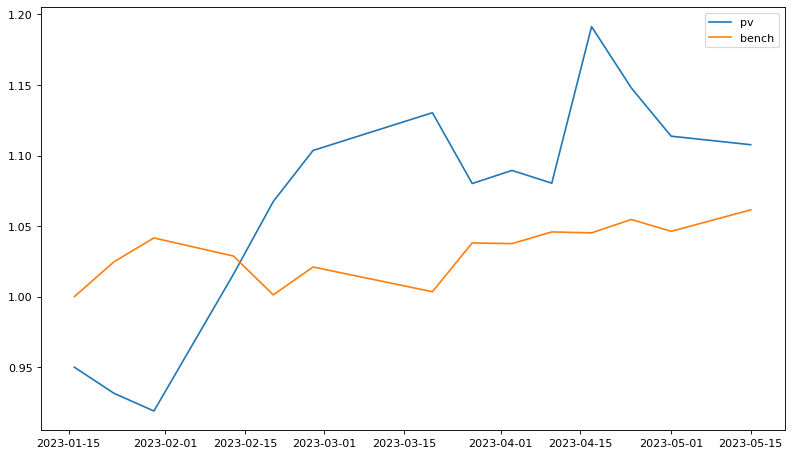

In [141]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])